In [185]:
import autograd
import autograd.numpy as np
import matplotlib.pyplot as plt
from PIL import Image 
import os
import IPython.display
import time
from astropy.nddata.utils import Cutout2D
from scipy import ndimage

In [232]:
class BubbleEvent:
    def __init__(self, File):
        self.FileName = File
        self.Bot1PixelArray, self.Bot2PixelArray = BubbleEvent.GetPixelArray(self.FileName) #gets 2d array of pixel intensities
        self.Date, self.Run, self.EventID = BubbleEvent.GetRunInfo(self.FileName) #parses image name to get event info
        self.BubbleCount = 0
    def GetPixelArray(FileName):
        im = Image.open(FileName)
        PixelArray = np.asarray(im)
        Cutout = Cutout2D(PixelArray, (530,140), 235) #just cut out the parts of the image with bottles
        Bot1PixelArray = Cutout.data
        PixelArray =ndimage.rotate(PixelArray, -45)
        Cutout2 = Cutout2D(PixelArray, (270,310), 235) #other bottle view
        Bot2PixelArray = Cutout2.data
        return Bot1PixelArray, Bot2PixelArray
    def GetRunInfo(File):
        Date = int(File.split("/")[-1].split("_")[0]) #file should be date_run_event
        Run = int(File.split("/")[-1].split("_")[1])
        Event = int("{}{}{}".format(Date, Run,File.split("/")[-1].split("_")[2])) 
        return Date, Run, Event

def GetBubbleCount(Event, BubbleInfo):
    EventID = Event.EventID
    Cut = BubbleInfo[:,0]==EventID
    Event.BubbleCount = int(BubbleInfo[Cut,1])
    
def GetAllDiffImages():
    path = "../bubbleimages/diff/"
    Files = np.array(["{}{}".format(path,file) for file in os.listdir(path) if os.path.isfile(os.path.join(path, file))])
    return Files

In [233]:
BubbleCountInfo = np.genfromtxt("bubnums.csv", delimiter=", ")
DiffImages = GetAllDiffImages()
Events = []
Start=time.time()
for i in range(0, len(DiffImages)):
    Event = BubbleEvent(DiffImages[i])
    GetBubbleCount(Event, BubbleCountInfo)
    Events.append(Event)
    if(i%int(len(DiffImages)/10) == 0 ):
        print("On {} of {}, {}".format(i, len(DiffImages), time.time()-Start))
Events = np.asarray(Events, dtype=BubbleEvent) #make an np array to make things nicer

On 0 of 2332, 0.04650568962097168
On 233 of 2332, 10.848945617675781
On 466 of 2332, 21.55796790122986
On 699 of 2332, 32.283788204193115
On 932 of 2332, 43.05053186416626
On 1165 of 2332, 53.80598497390747
On 1398 of 2332, 64.53181791305542
On 1631 of 2332, 75.21278095245361
On 1864 of 2332, 86.19618678092957
On 2097 of 2332, 96.89624834060669
On 2330 of 2332, 107.61276030540466


In [242]:
#extract useful params for our events with a diff image
def ExtractBubbles(event):
    return event.BubbleCount

#Doesnt work well
def GetPixelArrays(events):
    Pixels=[]
    for i in range(0, len(events)):
        Pixels.append([events[i].Bot1PixelArray, events[i].Bot2PixelArray])
    Pixels = np.array(Pixels)
    return Pixels

GetCountArray = np.vectorize(ExtractBubbles)
Counts = GetCountArray(Events)
PixelArrays = GetPixelArrays(Events)
for i in range(0, max(Counts)+1):
    Cut = Counts==i
    print("{} Events with {} Bubbles".format(Cut.sum(), i))

1551 Events with 0 Bubbles
755 Events with 1 Bubbles
25 Events with 2 Bubbles
1 Events with 3 Bubbles


In [ ]:
def DownSampleTheArray(BoxSize, Array):
    NewArray = np.zeros((int(np.shape(Array)[0]/BoxSize), int(np.shape(Array)[1]/BoxSize)))
    NewI=0
    NewJ=0
    i=0
    j=0
    while(NewI<np.shape(NewArray)[0]):
        NewJ=0
        j=0
        while(NewJ<np.shape(NewArray)[1]):
            NewArray[NewI, NewJ] = np.mean(Array[i:i+BoxSize, j:j+BoxSize])
            j = j + BoxSize
            NewJ = NewJ+1
        i = i + BoxSize
        NewI = NewI+1
    return NewArray

def GetEdgeFeatures(PixelArray):
    HorizontalKernal = np.array([[1,0,-1],[2,0,-2], [1,0,-1]])
    VerticalKernal = HorizontalKernal.T
    EdgeArray = np.zeros(3) #histograms of edge directions
    Step = 3
    i=0
    j=0
    Significant = 35
    while(i < np.shape(PixelArray)[0]-2):
        j=0
        while(j < np.shape(PixelArray)[1]-2):
            XConvalution = PixelArray[i:i+Step, j:j+Step]*HorizontalKernal
            XConvalution = np.sum(XConvalution)
            YConvalution = PixelArray[i:i+Step, j:j+Step]*VerticalKernal
            YConvalution = np.sum(YConvalution)
            #histogram and adding convalution result seem to perform similarly
            if(np.abs(XConvalution)>Significant and np.abs(YConvalution)<=Significant):
                EdgeArray[0] = EdgeArray[0]+ np.abs(XConvalution) #big horizontal edge
            elif(np.abs(XConvalution)<=Significant and np.abs(YConvalution)>Significant):
                EdgeArray[1] = EdgeArray[1]+ np.abs(YConvalution) #big verical edge
            elif(np.abs(XConvalution)>Significant and np.abs(YConvalution)>Significant):
                EdgeArray[2] = EdgeArray[2]+ np.abs(XConvalution) + np.abs(YConvalution) #big diagonal
            #j =j+Step
            j=j+1
        #i =i+Step
        i=i+1
    return EdgeArray

for i in range(0, 0):
    print("{} Bubbles in {}".format(Counts[i], Events[i].FileName))
    plt.figure(figsize=(10,10))
    fig, axs = plt.subplots(1, 2, figsize=(13,13))
    #2 does good. 5+ does good on all but first one
    Temp1 = DownSampleTheArray(2, PixelArrays[i][0])
    Edge1 = GetEdgeFeatures(Temp1)
    Temp2 = DownSampleTheArray(2, PixelArrays[i][1])
    Edge2 = GetEdgeFeatures(Temp2)
    print(Edge1+Edge2, np.sum(Edge1+Edge2))
    axs[0].imshow(Temp1)
    axs[1].imshow(Temp2)
    plt.show()
    
for i in range(0, max(Counts)+1):
    Cut = Counts==i
    CheckingHist = np.zeros(Cut.sum())
    for j in range(0, Cut.sum()):
        Temp1 = DownSampleTheArray(2, PixelArrays[Cut][j][0])
        Edge1 = GetEdgeFeatures(Temp1)
        Temp2 = DownSampleTheArray(2, PixelArrays[Cut][j][1])
        Edge2 = GetEdgeFeatures(Temp2)
        CheckingHist[j] = np.sum(Edge1+Edge2)
    plt.hist(CheckingHist, histtype="step", range=[0,40000], bins=200, label="{} Bubbles".format(i))
plt.legend()
plt.show()

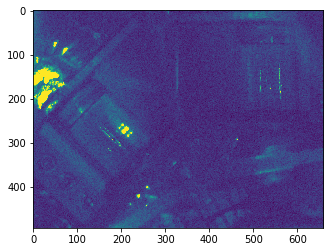

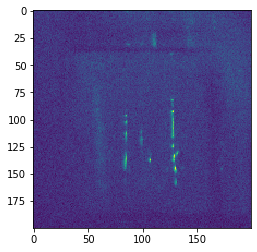

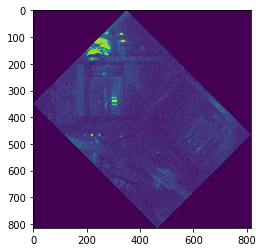

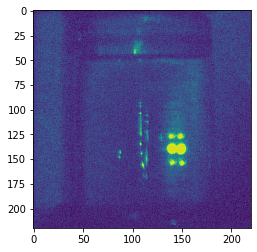

In [196]:
#Just have the jar parts

im = Image.open("../bubbleimages/trig/20170925_0_63_trig.bmp")
Array = np.asarray(im, dtype=int)
IVals = np.arange(0, np.shape(Array)[0],1)
JVals = np.arange(0, np.shape(Array)[1],1)

Cut1 = (IVals>-10)*(IVals<2750)
plt.imshow(Array[Cut1,:])
plt.show()
Cutout = Cutout2D(Array, (530,140), 200)
plt.imshow(Cutout.data)
plt.show()

Array=ndimage.rotate(Array, -45)
plt.imshow(Array)
plt.show()
Cutout2 = Cutout2D(Array, (270,310), 220)
plt.imshow(Cutout2.data)
plt.show()